In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
np.object = object  
np.int = int    
np.bool = bool 
np.float = float
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import gc
import joblib

save_dir = './saved_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

rcParams['font.sans-serif'] = ['Microsoft Yahei']  # 设置默认字体
rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

In [34]:
#a_time_periods = [('2024-01-01 08:00', '2024-01-01 10:00'), ('2024-01-02 14:00', '2024-01-02 16:00')]
ramp_closures = [
        # 國慶日
    ('2023-10-07 00:00:00','2023-10-08 23:59:00'), # 石碇-坪林
        # 中秋節
    ('2023-09-29 00:00:00','2023-09-30 23:59:00'), # 石碇-坪林
        # 端午節
    ('2023-06-22 00:00:00','2023-06-23 23:59:00'), # 石碇-坪林
        # 端午節
    ('2023-04-01 00:00:00','2023-04-02 23:59:00'), # 石碇-坪林
        # 228
    ('2023-02-25 00:00:00','2023-02-26 23:59:00'), # 石碇-坪林
        # 春節
    ('2023-01-22 00:00:00','2023-01-24 23:59:00'), # 石碇-坪林   
        # 元旦
    ('2022-12-31 00:00:00', '2023-01-01 23:59:00'), # 石碇-坪林
    
    # 可以添加更多日期和起終點
]
open_shoulder_conditions = [
    ('2023-01-19 00:00:00' , '2023-01-19 23:59:00'), # 春節
    ('2023-02-24 00:00:00' , '2023-02-24 23:59:00'), # 228
    ('2023-06-21 00:00:00' , '2023-06-21 23:59:00'), # 端午節
    ('2023-09-28 00:00:00' , '2023-09-28 23:59:00'), # 中秋
    ('2023-10-06 00:00:00' , '2023-10-06 23:59:00'), # 228
]
high_loads = [
    ('2023-10-08 13:00:00','2023-10-08 18:00:00'),
    ('2023-10-09 13:00:00','2023-10-09 18:00:00'),
    ('2023-10-10 13:00:00','2023-10-10 18:00:00'),

    # 中秋節
    ('2023-09-30 13:00:00','2023-09-30 18:00:00'),
    ('2023-10-01 13:00:00','2023-10-01 18:00:00'),
    
    # 端午節
    ('2023-06-24 13:00:00', '2023-06-24 18:00:00'),
    ('2023-06-25 13:00:00', '2023-06-25 18:00:00'),
    
    # 清明節
    ('2023-04-02 13:00:00','2023-04-02 18:00:00'),
    ('2023-04-03 13:00:00','2023-04-03 18:00:00'),
    ('2023-04-04 13:00:00','2023-04-04 18:00:00'),
    ('2023-04-05 13:00:00','2023-04-05 18:00:00'),
    
    # 228
    ('2023-02-27 14:00:00','2023-02-27 21:00:00'),
    ('2023-02-28 14:00:00','2023-02-28 21:00:00'),
    
    # 春節
    ('2023-01-24 15:00:00','2023-01-24 20:00:00'),
    ('2023-01-25 15:00:00','2023-01-25 20:00:00'),
    ('2023-01-26 15:00:00','2023-01-26 20:00:00'),
    ('2023-01-27 15:00:00','2023-01-27 20:00:00'),
    ('2023-01-28 15:00:00','2023-01-28 20:00:00'),
    ('2023-01-29 15:00:00','2023-01-29 20:00:00'),
    
    # 元旦
    ('2023-01-01 14:00:00','2023-01-02 21:00:00'),
    ('2023-01-02 14:00:00','2023-01-02 21:00:00')]


high_occupancy_locations = ['05F0258N', '05F0438N', '05FR143N','05F0309N']
ramp_closures_locations = ['05F0000S', '05F0055S','05F0287S']
open_shoulder_locations = ['03F0201N', '05F0000S']

In [35]:
# Load the mapping file
mapping_file = r'./route_mapping.csv'
route_mapping = pd.read_csv(mapping_file)
route_dict = {row['route_code']: row['route_name'] for _, row in route_mapping.iterrows()}

def create_features(df, high_loads, high_occupancy_locations, ramp_closures, ramp_closures_locations, open_shoulder_conditions, open_shoulder_locations):
    df['hour'] = df['時間'].dt.hour
    df['dayofweek'] = df['時間'].dt.dayofweek
    df['month'] = df['時間'].dt.month
    df['lag1'] = df['平均速度'].shift(1)
    df['lag2'] = df['平均速度'].shift(2)
    df['moving_avg_3'] = df['平均速度'].rolling(window=3).mean()
    #df['high_load'] = ((df['dayofweek'] == 6) & (df['hour'] >= 15) & (df['hour'] <= 20)).astype(int)
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    # 新增手段A特征
    #df['高乘載'] = ((df['dayofweek'] == 6) & (df['hour'] >= 15) & (df['hour'] <= 20)).astype(int)  # 示例逻辑
    
    df['高乘載'] = 0
    for start,end in high_loads:
        mask = ((df['時間'] >= start) & (df['時間'] <= end) | ((df['dayofweek'] == 6) & (df['hour'] >= 15) & (df['hour'] <= 20))) & df['起點路段'].isin(high_occupancy_locations)
        df.loc[mask,'高乘載'] = 1

    df['匝道封閉'] = 0
    for start, end in ramp_closures:
        mask = (df['時間'] >= start) & (df['時間'] <= end) & df['起點路段'].isin(ramp_closures_locations)
        df.loc[mask, '匝道封閉'] = 1

    # 添加手段 C
    df['路肩開放'] = 0
    for start, end in open_shoulder_conditions:
        mask = (df['時間'] >= start) & (df['時間'] <= end) & df['起點路段'].isin(open_shoulder_conditions)
        df.loc[mask, '路肩開放'] = 1


    df = df.dropna()  # 去除NaN值
    return df

In [36]:

# Load and preprocess the data
agg_file = r'./FilteredData/aggregated_data.csv'
aggregated_data = pd.read_csv(agg_file)
data_cleaned = aggregated_data.dropna(subset=['平均速度']).copy()
data_cleaned['時間'] = pd.to_datetime(data_cleaned['時間'])
data_cleaned = create_features(data_cleaned, high_loads, high_occupancy_locations, ramp_closures, ramp_closures_locations, open_shoulder_conditions, open_shoulder_locations)

# Filter the data
speed_threshold = 120
data_cleaned = data_cleaned[data_cleaned['平均速度'] <= speed_threshold]

# Group by 起点路段 and 终点路段
grouped = data_cleaned.groupby(['起點路段', '終點路段'])

Training model for route: 木柵&南深路(3) -> 南港系統
Epoch 1/40
2457/2457 [==============================] - 15s 4ms/step - loss: 127.2487 - val_loss: 46.7770
Epoch 2/40
2457/2457 [==============================] - 9s 4ms/step - loss: 64.0719 - val_loss: 46.9762
Epoch 3/40
2457/2457 [==============================] - 9s 4ms/step - loss: 63.8407 - val_loss: 46.9073
Epoch 4/40
2457/2457 [==============================] - 9s 4ms/step - loss: 63.8901 - val_loss: 47.1629
Epoch 5/40
2457/2457 [==============================] - 9s 4ms/step - loss: 63.5472 - val_loss: 46.7003
Epoch 6/40
2457/2457 [==============================] - 9s 4ms/step - loss: 61.8780 - val_loss: 38.6893
Epoch 7/40
2457/2457 [==============================] - 9s 4ms/step - loss: 14.1404 - val_loss: 1.9630
Epoch 8/40
2457/2457 [==============================] - 9s 4ms/step - loss: 7.0229 - val_loss: 0.9947
Epoch 9/40
2457/2457 [==============================] - 9s 4ms/step - loss: 6.4232 - val_loss: 0.7622
Epoch 10/40
2457/2457 [

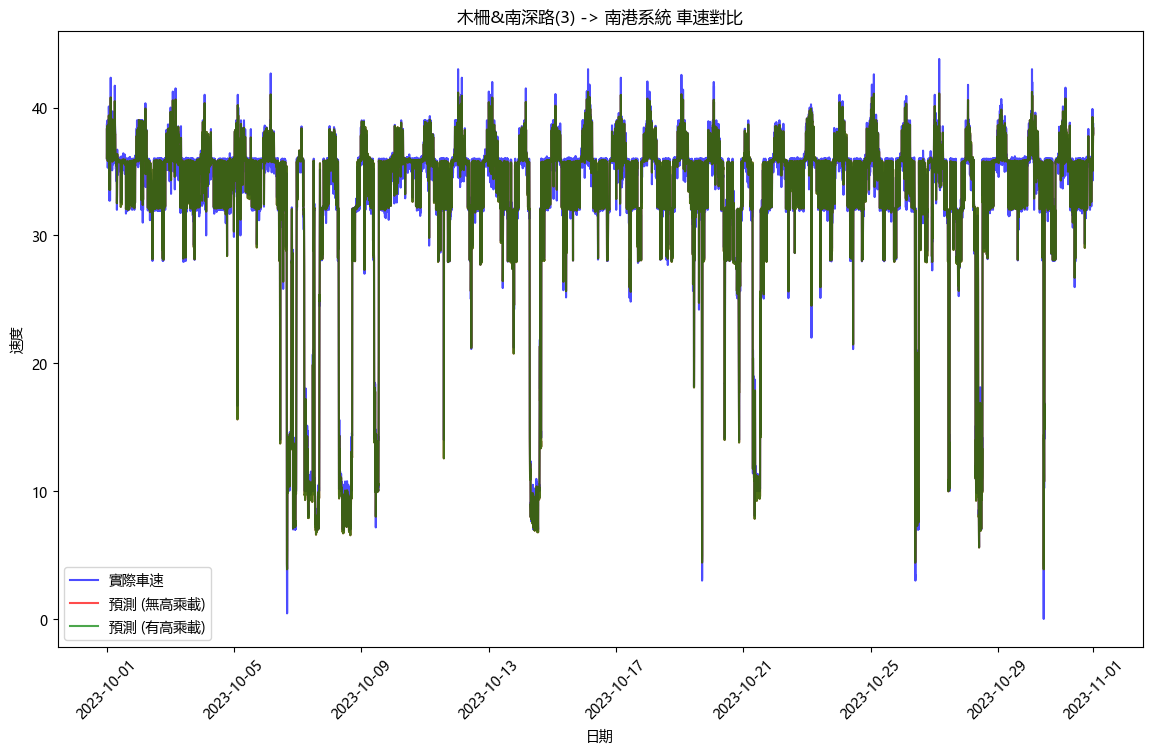

Training model for route: 南港(3) -> 南港系統
Epoch 1/40
2456/2456 [==============================] - 15s 4ms/step - loss: 865.2773 - val_loss: 184.1460
Epoch 2/40
2456/2456 [==============================] - 9s 4ms/step - loss: 247.8728 - val_loss: 180.0394
Epoch 3/40
2456/2456 [==============================] - 9s 4ms/step - loss: 202.6889 - val_loss: 21.3756
Epoch 4/40
2456/2456 [==============================] - 9s 4ms/step - loss: 29.2611 - val_loss: 2.1717
Epoch 5/40
2456/2456 [==============================] - 9s 4ms/step - loss: 24.7939 - val_loss: 1.6975
Epoch 6/40
2456/2456 [==============================] - 9s 4ms/step - loss: 23.6254 - val_loss: 1.3336
Epoch 7/40
2456/2456 [==============================] - 9s 4ms/step - loss: 22.6642 - val_loss: 4.3127
Epoch 8/40
2456/2456 [==============================] - 9s 4ms/step - loss: 21.9881 - val_loss: 0.7315
Epoch 9/40
2456/2456 [==============================] - 9s 4ms/step - loss: 21.2581 - val_loss: 1.9689
Epoch 10/40
2456/2456 [=

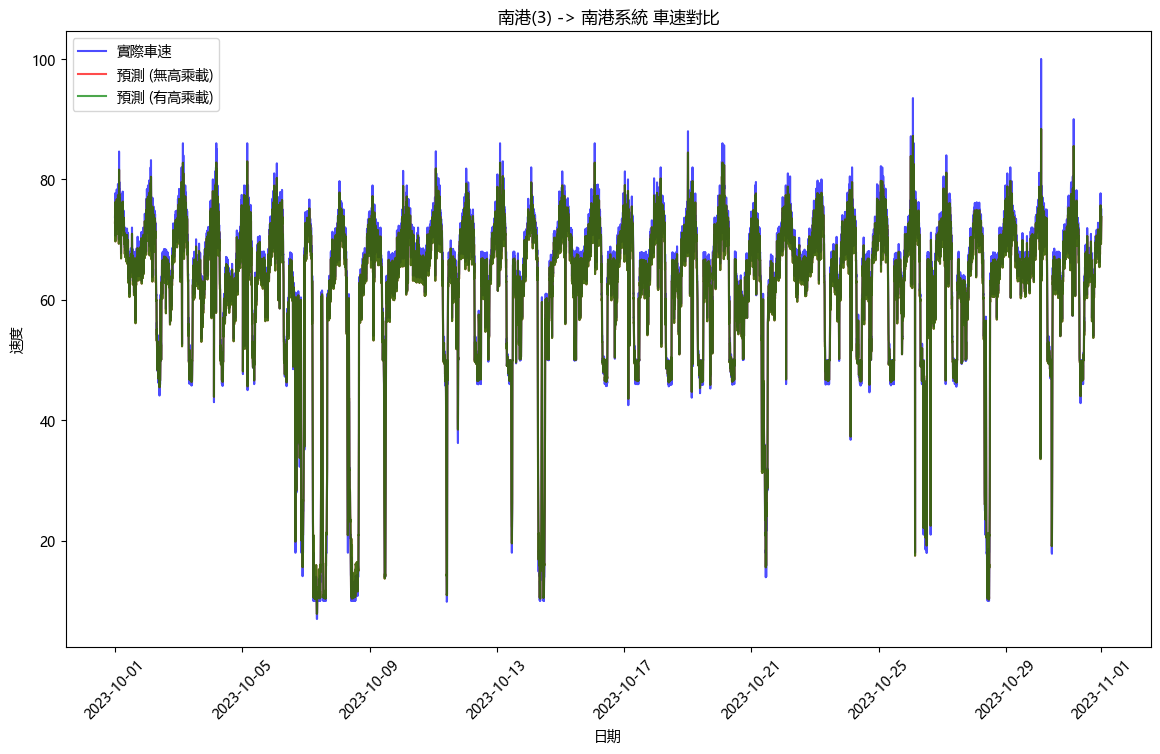

Training model for route: 南港系統 -> 石碇
Epoch 1/40
2455/2455 [==============================] - 15s 4ms/step - loss: 1314.4774 - val_loss: 125.1807
Epoch 2/40
2455/2455 [==============================] - 9s 4ms/step - loss: 219.0204 - val_loss: 86.6191
Epoch 3/40
2455/2455 [==============================] - 9s 4ms/step - loss: 216.1868 - val_loss: 87.2556
Epoch 4/40
2455/2455 [==============================] - 9s 4ms/step - loss: 216.7798 - val_loss: 87.4712
Epoch 5/40
2455/2455 [==============================] - 9s 4ms/step - loss: 216.3779 - val_loss: 87.0896
Epoch 6/40
2455/2455 [==============================] - 10s 4ms/step - loss: 208.8483 - val_loss: 51.4369
Epoch 7/40
2455/2455 [==============================] - 9s 4ms/step - loss: 43.0748 - val_loss: 3.8490
Epoch 8/40
2455/2455 [==============================] - 10s 4ms/step - loss: 33.0502 - val_loss: 3.4148
Epoch 9/40
2455/2455 [==============================] - 9s 4ms/step - loss: 31.5233 - val_loss: 3.1107
Epoch 10/40
2455/24

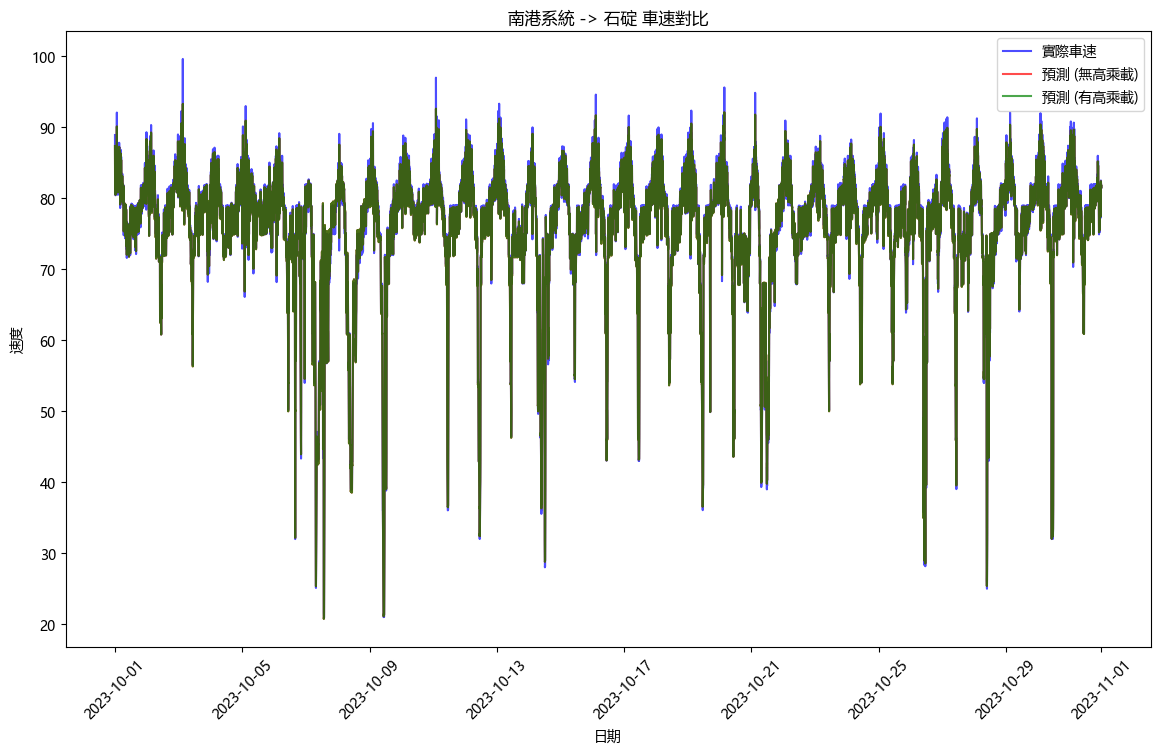

Training model for route: 南港系統 -> 南港(3)
Epoch 1/40
2455/2455 [==============================] - 15s 4ms/step - loss: 2792.2837 - val_loss: 287.9287
Epoch 2/40
2455/2455 [==============================] - 9s 4ms/step - loss: 133.8890 - val_loss: 82.0839
Epoch 3/40
2455/2455 [==============================] - 9s 4ms/step - loss: 92.1484 - val_loss: 82.2688
Epoch 4/40
2455/2455 [==============================] - 9s 4ms/step - loss: 91.6495 - val_loss: 81.7165
Epoch 5/40
2455/2455 [==============================] - 9s 4ms/step - loss: 90.9568 - val_loss: 82.1591
Epoch 6/40
2455/2455 [==============================] - 9s 4ms/step - loss: 91.0058 - val_loss: 82.4483
Epoch 7/40
2455/2455 [==============================] - 9s 4ms/step - loss: 89.6065 - val_loss: 82.6798
Epoch 8/40
2455/2455 [==============================] - 9s 4ms/step - loss: 89.3614 - val_loss: 81.7601
Epoch 9/40
2455/2455 [==============================] - 9s 4ms/step - loss: 88.2656 - val_loss: 83.3830
Epoch 10/40
2455/24

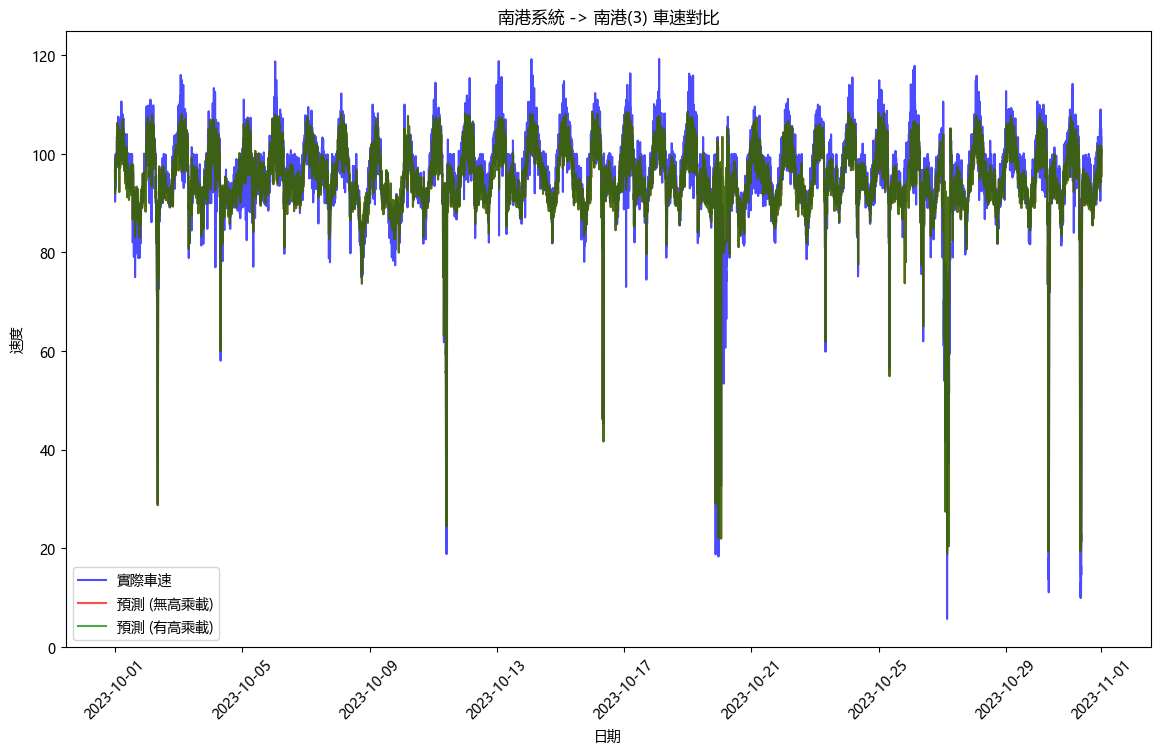

Training model for route: 南港系統 -> 木柵(3)
Epoch 1/40
2456/2456 [==============================] - 15s 4ms/step - loss: 685.5108 - val_loss: 93.0271
Epoch 2/40
2456/2456 [==============================] - 9s 4ms/step - loss: 94.8207 - val_loss: 93.6170
Epoch 3/40
2456/2456 [==============================] - 9s 4ms/step - loss: 94.2879 - val_loss: 93.1478
Epoch 4/40
2456/2456 [==============================] - 9s 4ms/step - loss: 94.0274 - val_loss: 93.4790
Epoch 5/40
2456/2456 [==============================] - 9s 4ms/step - loss: 93.8441 - val_loss: 93.5118
Epoch 6/40
2456/2456 [==============================] - 9s 4ms/step - loss: 93.6970 - val_loss: 93.7699
Epoch 7/40
2456/2456 [==============================] - 9s 4ms/step - loss: 79.2267 - val_loss: 61.9674
Epoch 8/40
2456/2456 [==============================] - 9s 4ms/step - loss: 63.7470 - val_loss: 52.4905
Epoch 9/40
2456/2456 [==============================] - 9s 4ms/step - loss: 47.3107 - val_loss: 36.5750
Epoch 10/40
2456/2456 

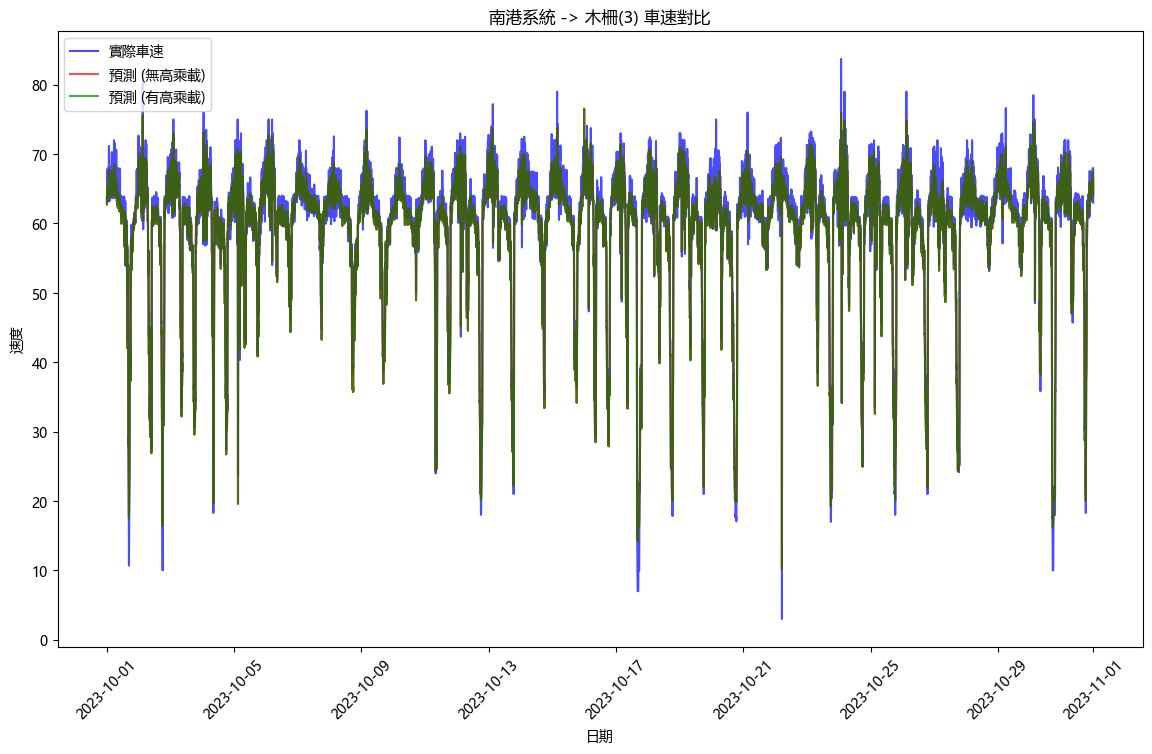

Training model for route: 石碇 -> 南港系統
Epoch 1/40
2456/2456 [==============================] - 15s 4ms/step - loss: 1555.3610 - val_loss: 137.7292
Epoch 2/40
2456/2456 [==============================] - 9s 4ms/step - loss: 145.3913 - val_loss: 96.2563
Epoch 3/40
2456/2456 [==============================] - 9s 4ms/step - loss: 140.3866 - val_loss: 96.2592
Epoch 4/40
2456/2456 [==============================] - 9s 4ms/step - loss: 140.5252 - val_loss: 96.3242
Epoch 5/40
2456/2456 [==============================] - 9s 4ms/step - loss: 139.8472 - val_loss: 96.2548
Epoch 6/40
2456/2456 [==============================] - 9s 4ms/step - loss: 129.1892 - val_loss: 22.9072
Epoch 7/40
2456/2456 [==============================] - 9s 4ms/step - loss: 42.2890 - val_loss: 5.4251
Epoch 8/40
2456/2456 [==============================] - 9s 4ms/step - loss: 36.1363 - val_loss: 2.1208
Epoch 9/40
2456/2456 [==============================] - 9s 4ms/step - loss: 33.8074 - val_loss: 2.0876
Epoch 10/40
2456/2456

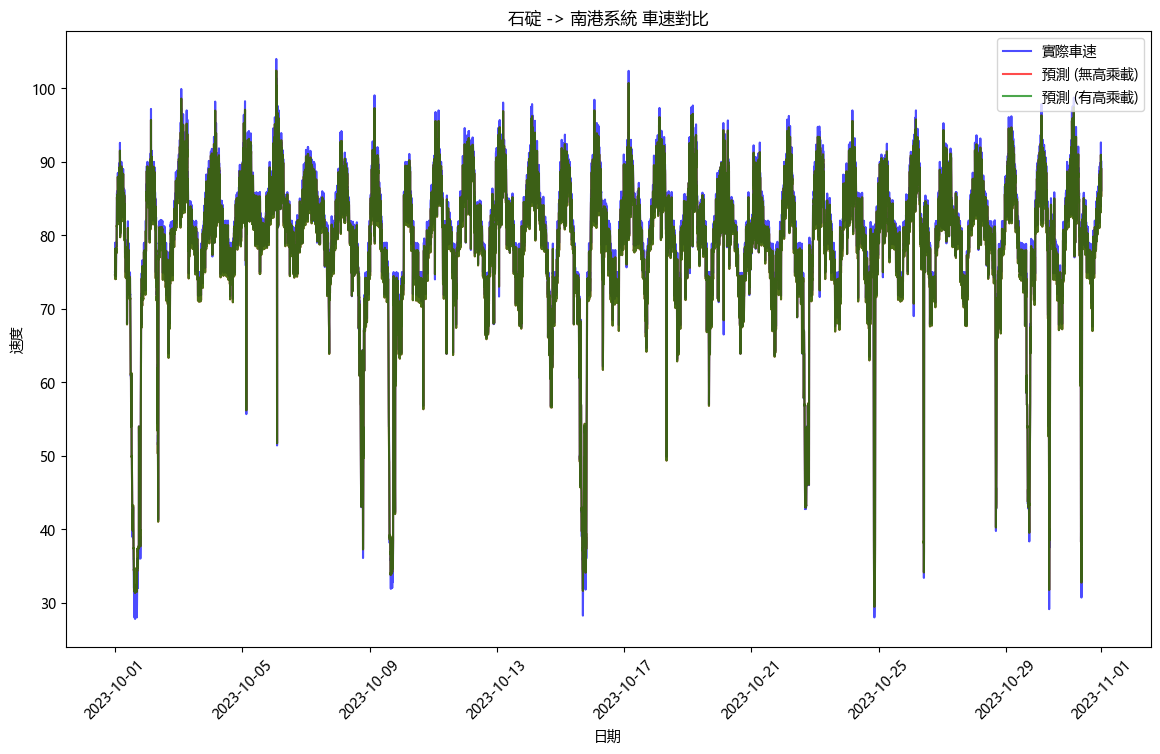

Training model for route: 石碇 -> 坪林
Epoch 1/40
2455/2455 [==============================] - 15s 4ms/step - loss: 1511.7212 - val_loss: 158.9243
Epoch 2/40
2455/2455 [==============================] - 9s 4ms/step - loss: 205.0559 - val_loss: 97.0198
Epoch 3/40
2455/2455 [==============================] - 9s 4ms/step - loss: 199.9473 - val_loss: 98.1823
Epoch 4/40
2455/2455 [==============================] - 9s 4ms/step - loss: 201.2220 - val_loss: 97.0959
Epoch 5/40
2455/2455 [==============================] - 9s 4ms/step - loss: 64.0910 - val_loss: 4.9279
Epoch 6/40
2455/2455 [==============================] - 9s 4ms/step - loss: 35.9417 - val_loss: 3.1174
Epoch 7/40
2455/2455 [==============================] - 9s 4ms/step - loss: 33.7224 - val_loss: 2.4213
Epoch 8/40
2455/2455 [==============================] - 10s 4ms/step - loss: 32.1654 - val_loss: 2.4203
Epoch 9/40
2455/2455 [==============================] - 9s 4ms/step - loss: 31.0602 - val_loss: 3.7765
Epoch 10/40
2455/2455 [===

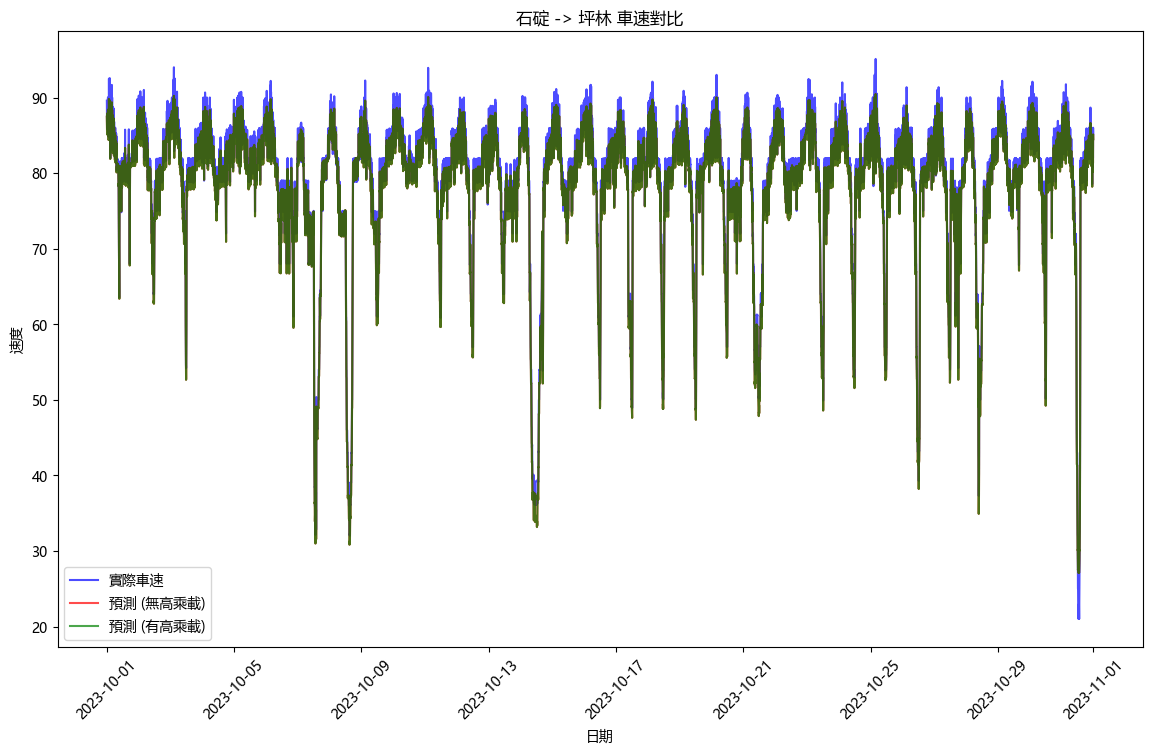

Training model for route: 坪林 -> 石碇
Epoch 1/40
2454/2454 [==============================] - 15s 4ms/step - loss: 1338.7200 - val_loss: 215.4811
Epoch 2/40
2454/2454 [==============================] - 9s 4ms/step - loss: 223.5363 - val_loss: 188.7003
Epoch 3/40
2454/2454 [==============================] - 9s 4ms/step - loss: 221.8967 - val_loss: 188.5440
Epoch 4/40
2454/2454 [==============================] - 9s 4ms/step - loss: 220.4542 - val_loss: 188.9209
Epoch 5/40
2454/2454 [==============================] - 9s 4ms/step - loss: 94.1993 - val_loss: 5.4611
Epoch 6/40
2454/2454 [==============================] - 9s 4ms/step - loss: 33.2878 - val_loss: 2.4949
Epoch 7/40
2454/2454 [==============================] - 9s 4ms/step - loss: 31.0787 - val_loss: 3.2318
Epoch 8/40
2454/2454 [==============================] - 9s 4ms/step - loss: 29.7307 - val_loss: 3.6024
Epoch 9/40
2454/2454 [==============================] - 9s 4ms/step - loss: 29.0777 - val_loss: 1.7900
Epoch 10/40
2454/2454 [=

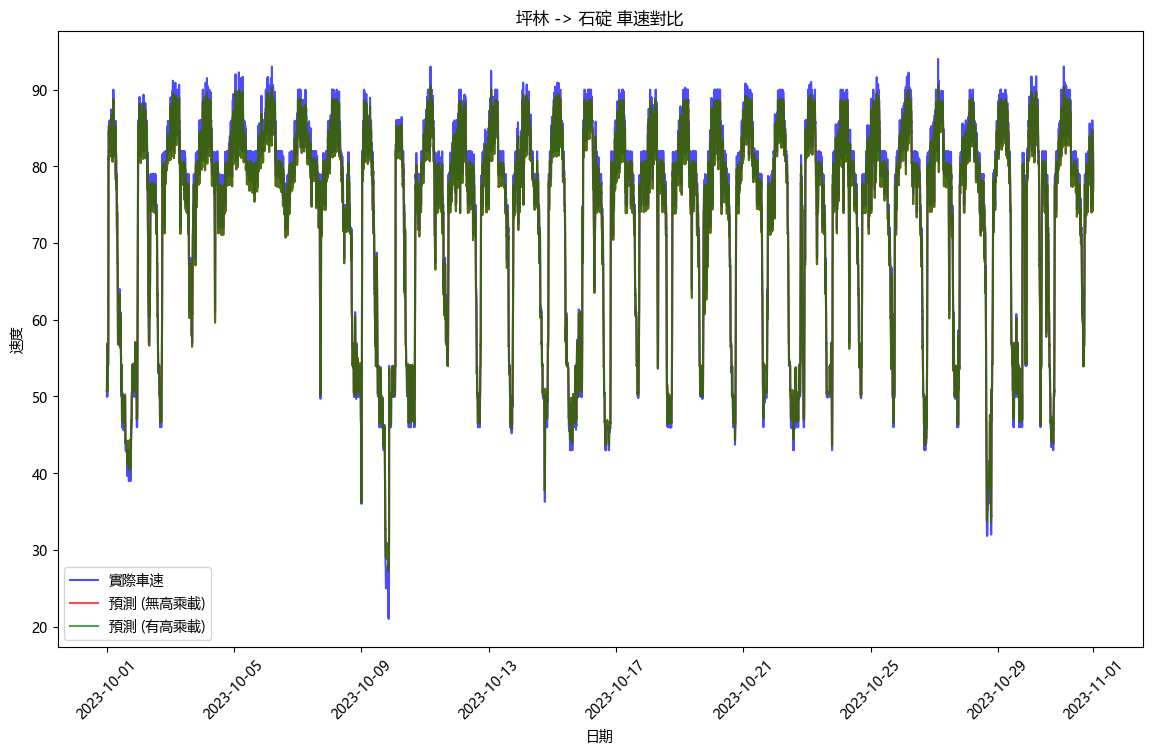

Training model for route: 坪林 -> 頭城
Epoch 1/40
2456/2456 [==============================] - 16s 4ms/step - loss: 2089.2363 - val_loss: 135.0033
Epoch 2/40
2456/2456 [==============================] - 9s 4ms/step - loss: 76.1269 - val_loss: 13.6865
Epoch 3/40
2456/2456 [==============================] - 9s 4ms/step - loss: 58.4337 - val_loss: 13.7149
Epoch 4/40
2456/2456 [==============================] - 9s 4ms/step - loss: 58.3516 - val_loss: 13.7425
Epoch 5/40
2456/2456 [==============================] - 9s 4ms/step - loss: 58.1315 - val_loss: 13.7003
Epoch 6/40
2456/2456 [==============================] - 9s 4ms/step - loss: 56.6877 - val_loss: 13.7228
Epoch 7/40
2456/2456 [==============================] - 9s 4ms/step - loss: 55.3479 - val_loss: 9.3276
Epoch 8/40
2456/2456 [==============================] - 9s 4ms/step - loss: 48.3695 - val_loss: 7.7373
Epoch 9/40
2456/2456 [==============================] - 9s 4ms/step - loss: 42.6994 - val_loss: 6.4315
Epoch 10/40
2456/2456 [=====

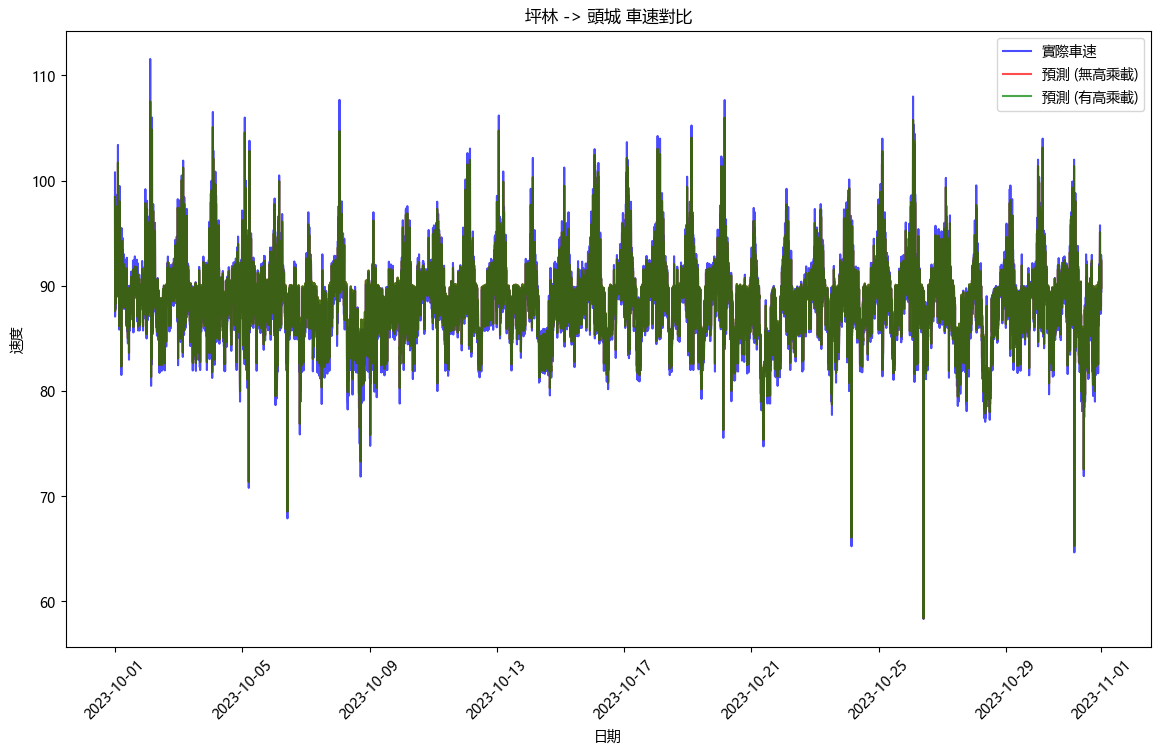

Training model for route: 頭城 -> 坪林
Epoch 1/40
2455/2455 [==============================] - 15s 4ms/step - loss: 1928.2451 - val_loss: 684.6464
Epoch 2/40
2455/2455 [==============================] - 9s 4ms/step - loss: 826.7130 - val_loss: 649.2220
Epoch 3/40
2455/2455 [==============================] - 9s 4ms/step - loss: 140.6889 - val_loss: 12.4909
Epoch 4/40
2455/2455 [==============================] - 9s 4ms/step - loss: 40.8264 - val_loss: 6.1133
Epoch 5/40
2455/2455 [==============================] - 9s 4ms/step - loss: 38.2528 - val_loss: 5.2114
Epoch 6/40
2455/2455 [==============================] - 9s 4ms/step - loss: 36.4191 - val_loss: 3.1505
Epoch 7/40
2455/2455 [==============================] - 9s 4ms/step - loss: 34.5641 - val_loss: 2.3679
Epoch 8/40
2455/2455 [==============================] - 9s 4ms/step - loss: 32.7217 - val_loss: 1.5522
Epoch 9/40
2455/2455 [==============================] - 9s 4ms/step - loss: 31.2193 - val_loss: 1.2553
Epoch 10/40
2455/2455 [=====

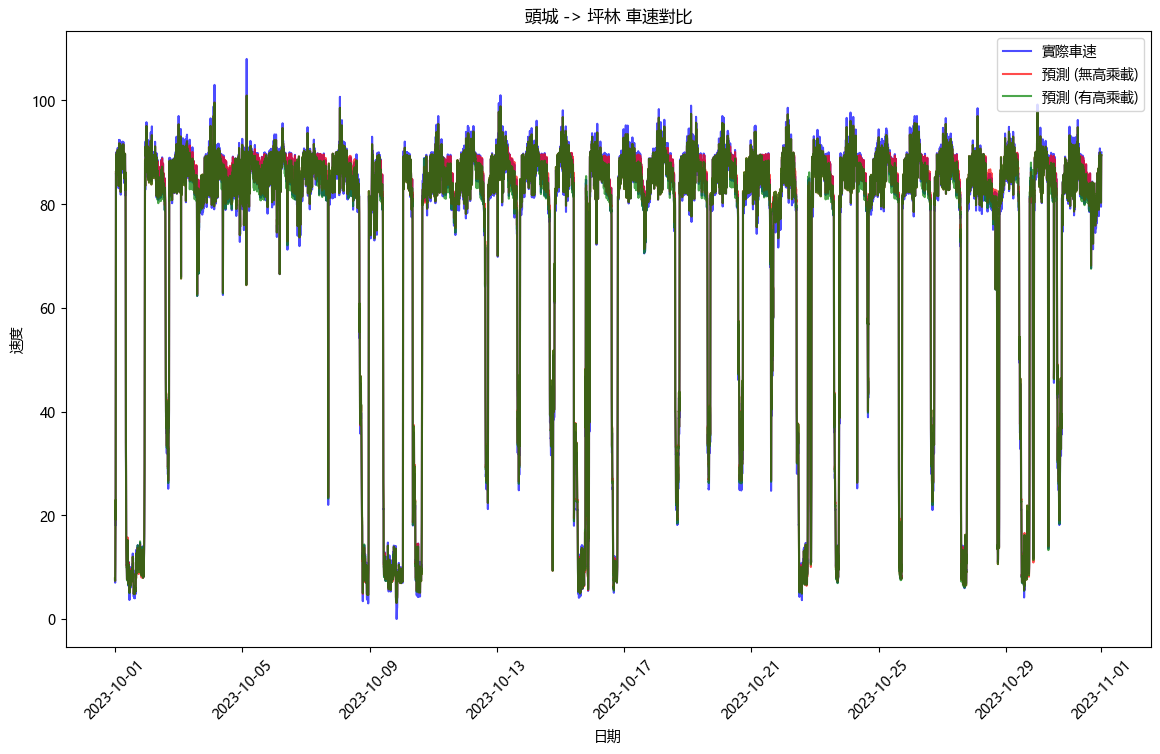

Training model for route: 頭城 -> 宜蘭北
Epoch 1/40
2457/2457 [==============================] - 15s 4ms/step - loss: 2402.3589 - val_loss: 184.2196
Epoch 2/40
2457/2457 [==============================] - 9s 4ms/step - loss: 83.1379 - val_loss: 9.2820
Epoch 3/40
2457/2457 [==============================] - 9s 4ms/step - loss: 55.4442 - val_loss: 9.2956
Epoch 4/40
2457/2457 [==============================] - 9s 4ms/step - loss: 54.9365 - val_loss: 9.2859
Epoch 5/40
2457/2457 [==============================] - 9s 4ms/step - loss: 54.9499 - val_loss: 9.2878
Epoch 6/40
2457/2457 [==============================] - 9s 4ms/step - loss: 53.9974 - val_loss: 9.1438
Epoch 7/40
2457/2457 [==============================] - 9s 4ms/step - loss: 51.2902 - val_loss: 8.1022
Epoch 8/40
2457/2457 [==============================] - 9s 4ms/step - loss: 49.7369 - val_loss: 7.0001
Epoch 9/40
2457/2457 [==============================] - 10s 4ms/step - loss: 46.4523 - val_loss: 5.4291
Epoch 10/40
2457/2457 [========

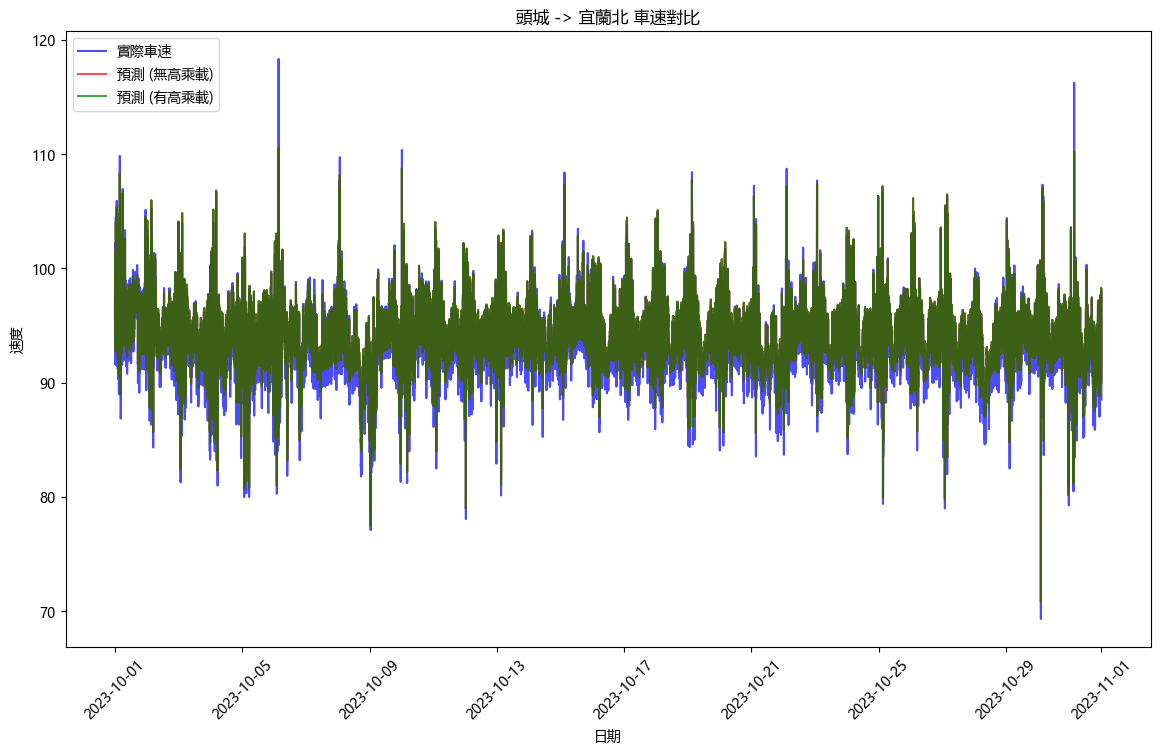

Training model for route: 宜蘭北 -> 頭城
Epoch 1/40
2457/2457 [==============================] - 15s 4ms/step - loss: 2164.0879 - val_loss: 326.0597
Epoch 2/40
2457/2457 [==============================] - 9s 4ms/step - loss: 342.6747 - val_loss: 212.5551
Epoch 3/40
2457/2457 [==============================] - 9s 4ms/step - loss: 221.3851 - val_loss: 16.7146
Epoch 4/40
2457/2457 [==============================] - 9s 4ms/step - loss: 50.5917 - val_loss: 13.9977
Epoch 5/40
2457/2457 [==============================] - 9s 4ms/step - loss: 47.4620 - val_loss: 4.7315
Epoch 6/40
2457/2457 [==============================] - 9s 4ms/step - loss: 43.9666 - val_loss: 6.0717
Epoch 7/40
2457/2457 [==============================] - 9s 4ms/step - loss: 42.4171 - val_loss: 3.5328
Epoch 8/40
2457/2457 [==============================] - 9s 4ms/step - loss: 41.1628 - val_loss: 3.6265
Epoch 9/40
2457/2457 [==============================] - 9s 4ms/step - loss: 40.4511 - val_loss: 3.6692
Epoch 10/40
2457/2457 [===

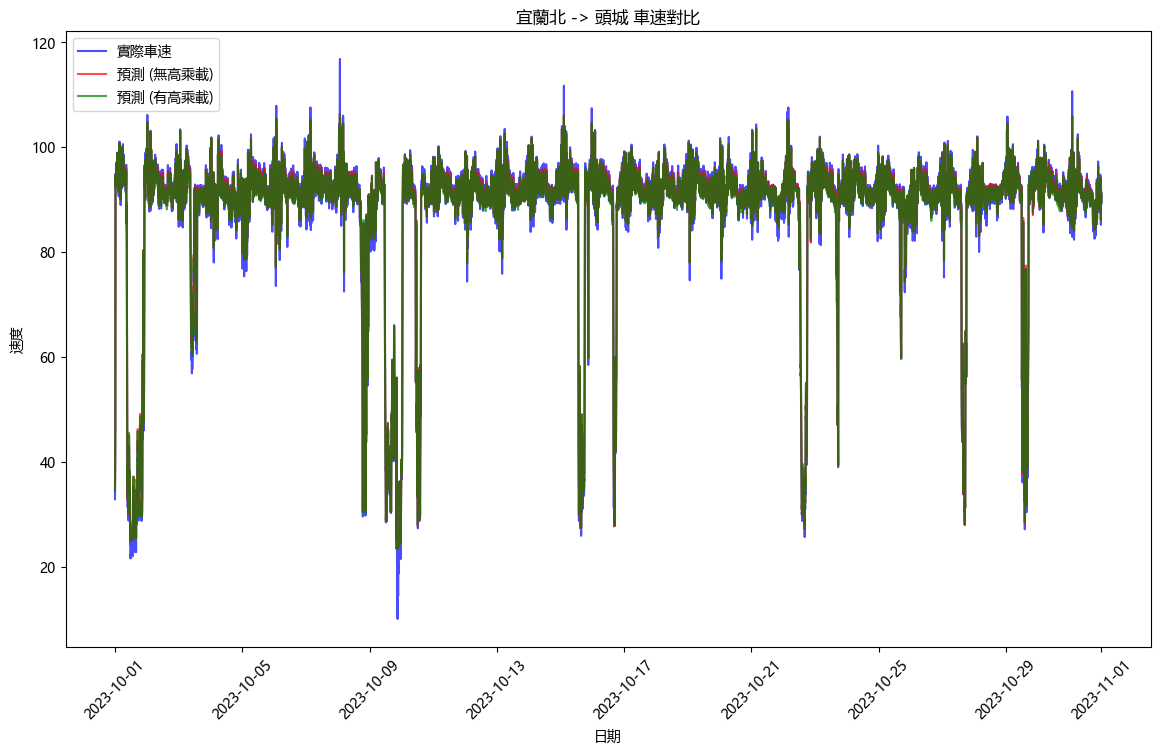

Training model for route: 羅東 -> 宜蘭南
Epoch 1/40
2343/2343 [==============================] - 15s 4ms/step - loss: 3033.0730 - val_loss: 366.1227
Epoch 2/40
2343/2343 [==============================] - 9s 4ms/step - loss: 145.0998 - val_loss: 37.0954
Epoch 3/40
2343/2343 [==============================] - 9s 4ms/step - loss: 80.4967 - val_loss: 37.4098
Epoch 4/40
2343/2343 [==============================] - 9s 4ms/step - loss: 80.4257 - val_loss: 37.3864
Epoch 5/40
2343/2343 [==============================] - 9s 4ms/step - loss: 79.8755 - val_loss: 37.8749
Epoch 6/40
2343/2343 [==============================] - 9s 4ms/step - loss: 79.1380 - val_loss: 37.4858
Epoch 7/40
2343/2343 [==============================] - 9s 4ms/step - loss: 78.4153 - val_loss: 37.6963
Epoch 8/40
2343/2343 [==============================] - 9s 4ms/step - loss: 77.3886 - val_loss: 37.6811
Epoch 9/40
2343/2343 [==============================] - 9s 4ms/step - loss: 76.4356 - val_loss: 35.7269
Epoch 10/40
2343/2343 [

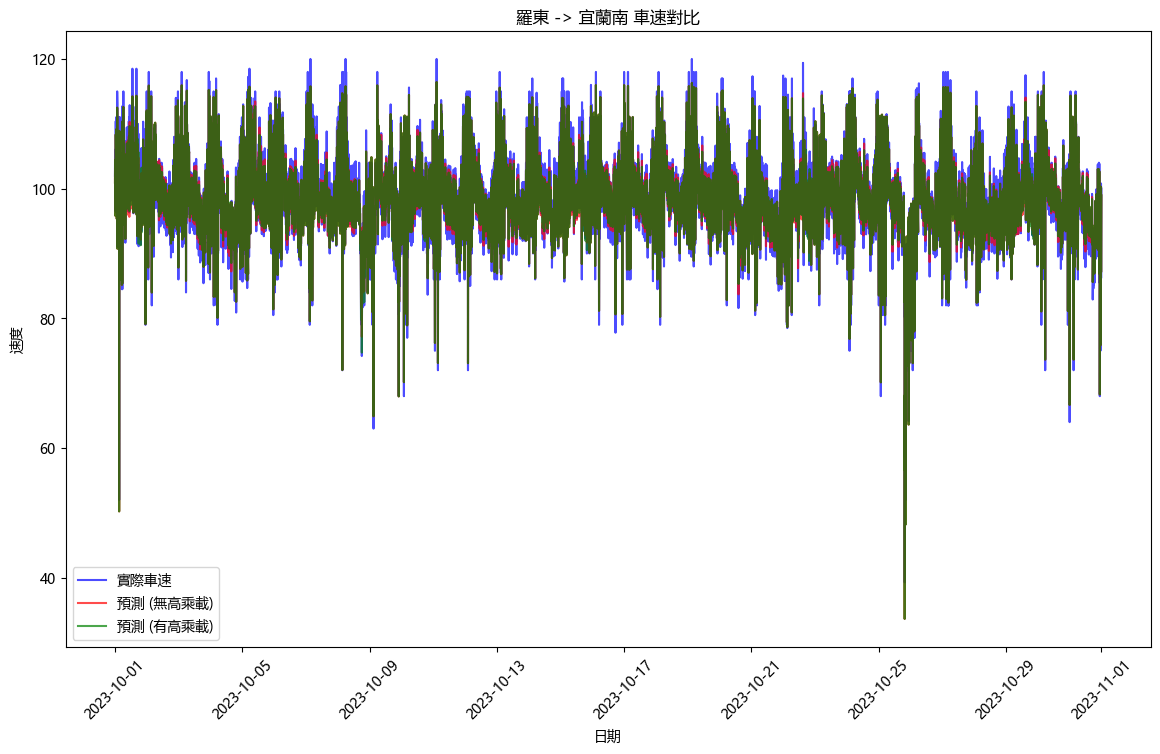

Training model for route: 羅東 -> 蘇澳
Epoch 1/40
2454/2454 [==============================] - 16s 4ms/step - loss: 2370.2241 - val_loss: 180.0407
Epoch 2/40
2454/2454 [==============================] - 10s 4ms/step - loss: 85.9329 - val_loss: 17.0651
Epoch 3/40
2454/2454 [==============================] - 9s 4ms/step - loss: 60.0892 - val_loss: 17.2041
Epoch 4/40
2454/2454 [==============================] - 9s 4ms/step - loss: 59.8135 - val_loss: 17.0570
Epoch 5/40
2454/2454 [==============================] - 9s 4ms/step - loss: 59.5492 - val_loss: 17.0632
Epoch 6/40
2454/2454 [==============================] - 9s 4ms/step - loss: 58.6731 - val_loss: 17.2420
Epoch 7/40
2454/2454 [==============================] - 9s 4ms/step - loss: 58.2399 - val_loss: 16.4879
Epoch 8/40
2454/2454 [==============================] - 9s 4ms/step - loss: 57.1504 - val_loss: 16.2778
Epoch 9/40
2454/2454 [==============================] - 9s 4ms/step - loss: 56.3057 - val_loss: 16.3243
Epoch 10/40
2454/2454 [=

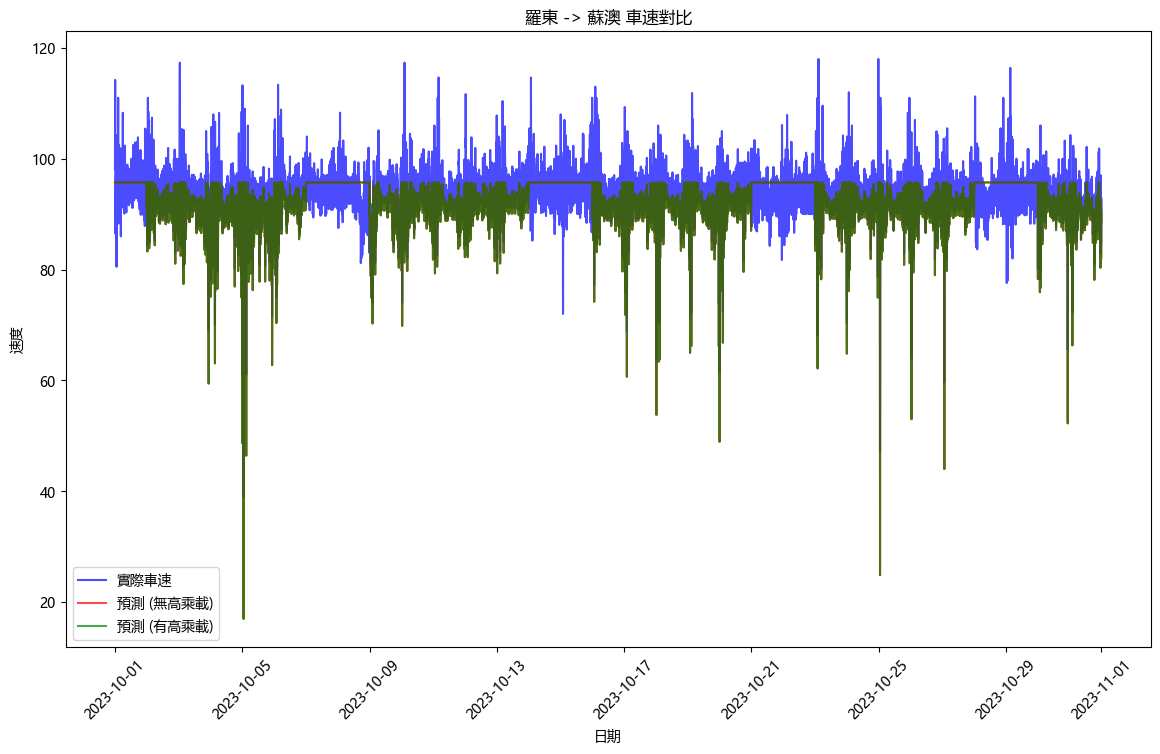

Training model for route: 羅東 -> 宜蘭北
Epoch 1/40
2451/2451 [==============================] - 15s 4ms/step - loss: 2319.7366 - val_loss: 172.4315
Epoch 2/40
2451/2451 [==============================] - 9s 4ms/step - loss: 88.7977 - val_loss: 21.3363
Epoch 3/40
2451/2451 [==============================] - 9s 4ms/step - loss: 64.6675 - val_loss: 21.2943
Epoch 4/40
2451/2451 [==============================] - 9s 4ms/step - loss: 64.2568 - val_loss: 21.7186
Epoch 5/40
2451/2451 [==============================] - 9s 4ms/step - loss: 63.8040 - val_loss: 21.6779
Epoch 6/40
2451/2451 [==============================] - 9s 4ms/step - loss: 63.2275 - val_loss: 20.5778
Epoch 7/40
2451/2451 [==============================] - 9s 4ms/step - loss: 57.3496 - val_loss: 13.0506
Epoch 8/40
2451/2451 [==============================] - 9s 4ms/step - loss: 48.9459 - val_loss: 3.0317
Epoch 9/40
2451/2451 [==============================] - 9s 4ms/step - loss: 44.2337 - val_loss: 1.6885
Epoch 10/40
2451/2451 [===

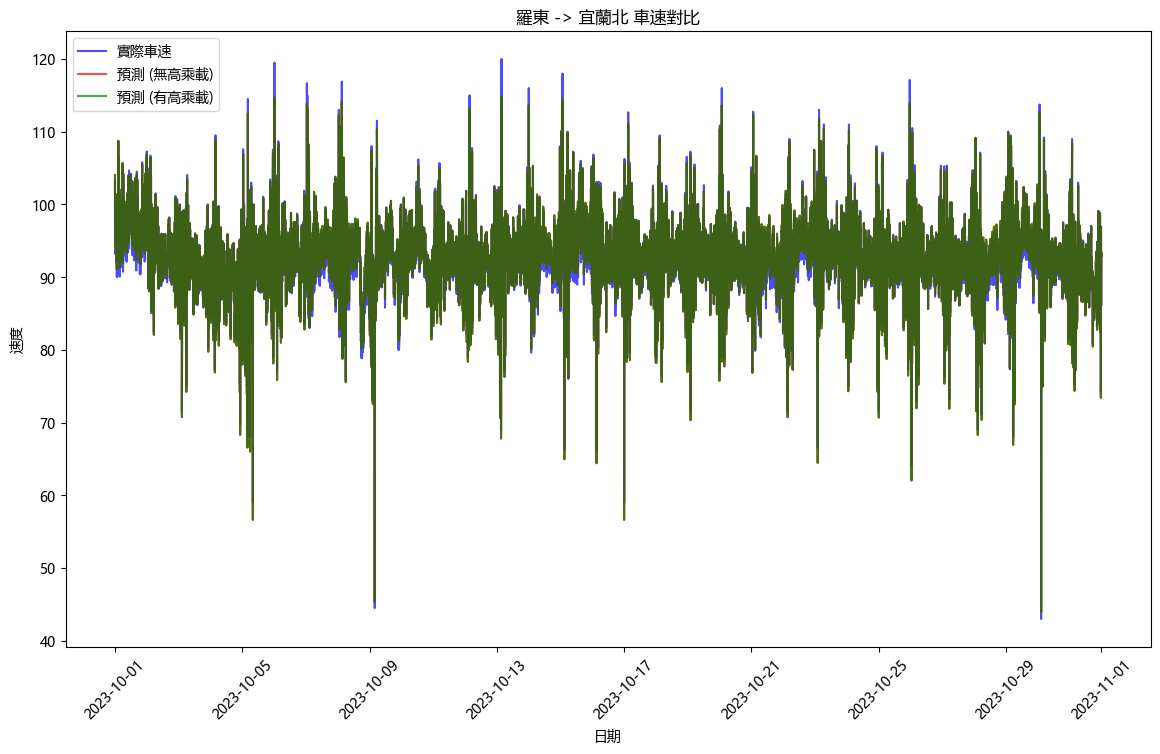

Training model for route: 宜蘭南 -> 羅東
Epoch 1/40
2385/2385 [==============================] - 15s 4ms/step - loss: 3077.1648 - val_loss: 371.9364
Epoch 2/40
2385/2385 [==============================] - 9s 4ms/step - loss: 145.1699 - val_loss: 33.6943
Epoch 3/40
2385/2385 [==============================] - 9s 4ms/step - loss: 80.9048 - val_loss: 33.7474
Epoch 4/40
2385/2385 [==============================] - 9s 4ms/step - loss: 79.9229 - val_loss: 33.8762
Epoch 5/40
2385/2385 [==============================] - 9s 4ms/step - loss: 80.4511 - val_loss: 33.7704
Epoch 6/40
2385/2385 [==============================] - 9s 4ms/step - loss: 79.6233 - val_loss: 34.1141
Epoch 7/40
2385/2385 [==============================] - 9s 4ms/step - loss: 78.0239 - val_loss: 23.9048
Epoch 8/40
2385/2385 [==============================] - 9s 4ms/step - loss: 60.6460 - val_loss: 4.4386
Epoch 9/40
2385/2385 [==============================] - 9s 4ms/step - loss: 51.1882 - val_loss: 1.9711
Epoch 10/40
2385/2385 [==

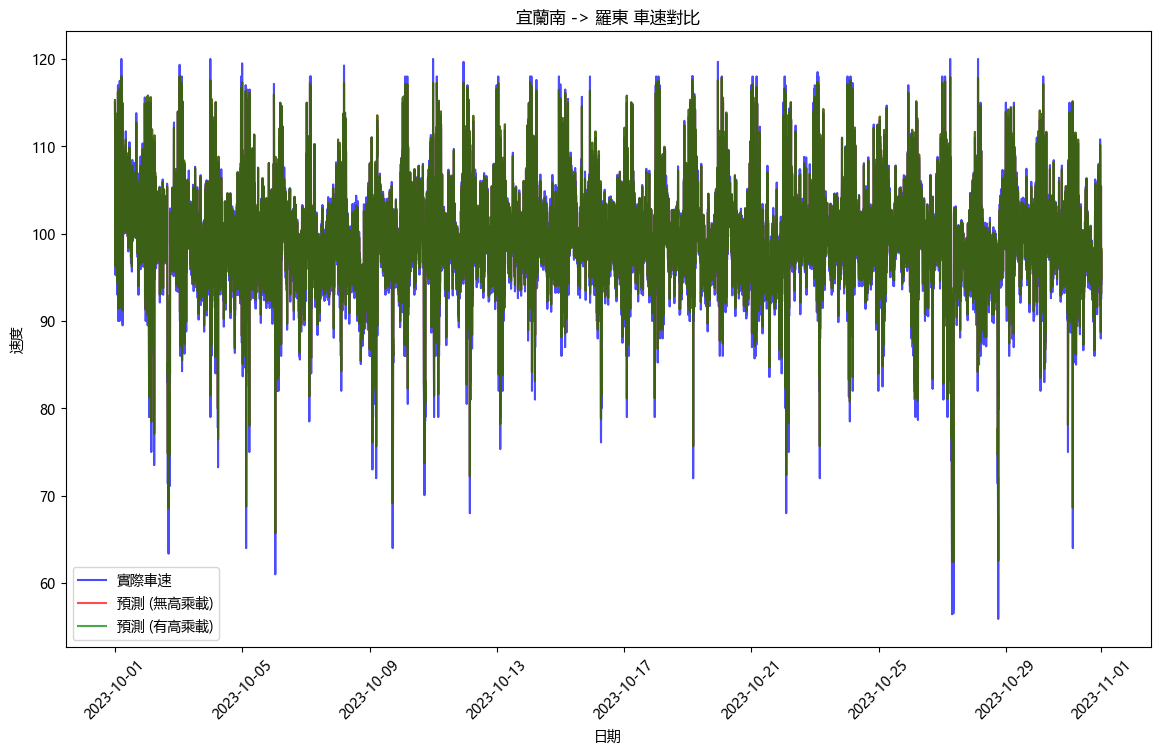

In [37]:
results = []
for (start_point, end_point), group in grouped:
    route_code = f"{start_point} -> {end_point}"
    route_name = route_dict.get(route_code, route_code)
    print(f"Training model for route: {route_name}")

    group = group.drop(columns=['終點路段'])

    # Split the data into training and testing sets
    train_data = group[group['時間'].dt.month <= 9]
    test_data = group[group['時間'].dt.month == 10]

    if len(train_data) == 0 or len(test_data) == 0:
        print(f"Skipping route {route_name} due to insufficient data")
        continue

    X_train_base = train_data.drop(columns=['平均速度', '時間'])
    y_train = train_data['平均速度']

    X_test_base = test_data.drop(columns=['平均速度', '時間'])
    y_test = test_data['平均速度']

    # Encode categorical features using OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(X_train_base[['起點路段']])
    X_train_encoded = encoder.transform(X_train_base[['起點路段']])
    X_test_encoded = encoder.transform(X_test_base[['起點路段']])

    # Drop the original categorical columns
    X_train_base = X_train_base.drop(columns=['起點路段'])
    X_test_base = X_test_base.drop(columns=['起點路段'])

    # Concatenate the encoded columns back to the dataframe
    X_train_base = np.hstack((X_train_base.values, X_train_encoded))
    X_test_base = np.hstack((X_test_base.values, X_test_encoded))

    # Normalize the feature columns
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_base)
    X_test_scaled = scaler.transform(X_test_base)

    # Reshape the data for LSTM input
    X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    # Build the LSTM model with dropout layers to prevent overfitting
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')

    # Train the model
    history = model.fit(X_train_reshaped, y_train, epochs=40, batch_size=32, validation_data=(X_test_reshaped, y_test))
    
    route_save_dir = os.path.join(save_dir, route_name.replace("->", "_to_").replace("&", "and").replace(" ", "").replace("/", "_"))
    if not os.path.exists(route_save_dir):
        os.makedirs(route_save_dir)
    
    # Save the encoder
    encoder_path = os.path.join(route_save_dir, 'encoder.pkl')
    joblib.dump(encoder, encoder_path)

    # Save the scaler
    scaler_path = os.path.join(route_save_dir, 'scaler.pkl')
    joblib.dump(scaler, scaler_path)

    # Save the model
    model_path = os.path.join(route_save_dir, 'model.h5')
    model.save(model_path)
    
    # Make predictions for the original test set
    y_pred_test_original = model.predict(X_test_reshaped)

    # Modify test data to simulate施行手段A
    test_data_with_measure = test_data.copy()
    measure_times = [
        ('2023-10-01 08:00:00', '2023-10-01 17:00:00'),
        ('2023-10-02 08:00:00', '2023-10-02 17:00:00'),
        ('2023-10-03 08:00:00', '2023-10-03 17:00:00'),
        ('2023-10-04 08:00:00', '2023-10-04 17:00:00'),
        ('2023-10-05 08:00:00', '2023-10-05 17:00:00'),
        ('2023-10-06 08:00:00', '2023-10-06 17:00:00'),
        ('2023-10-07 08:00:00', '2023-10-07 17:00:00'),
        ('2023-10-08 08:00:00', '2023-10-08 17:00:00'),
        ('2023-10-09 08:00:00', '2023-10-09 17:00:00'),
        ('2023-10-10 08:00:00', '2023-10-10 17:00:00'),
        ('2023-10-11 08:00:00', '2023-10-11 17:00:00'),
        ('2023-10-12 08:00:00', '2023-10-12 17:00:00'),
        ('2023-10-13 08:00:00', '2023-10-13 17:00:00'),
        ('2023-10-14 08:00:00', '2023-10-14 17:00:00'),
        ('2023-10-15 08:00:00', '2023-10-15 17:00:00'),
        ('2023-10-16 08:00:00', '2023-10-16 17:00:00'),
        ('2023-10-17 08:00:00', '2023-10-17 17:00:00'),
        ('2023-10-18 08:00:00', '2023-10-18 17:00:00'),
        ('2023-10-19 08:00:00', '2023-10-19 17:00:00'),
        ('2023-10-20 08:00:00', '2023-10-20 17:00:00'),
        ('2023-10-21 08:00:00', '2023-10-21 17:00:00'),
        ('2023-10-22 08:00:00', '2023-10-22 17:00:00'),
        ('2023-10-23 08:00:00', '2023-10-23 17:00:00'),
        ('2023-10-24 08:00:00', '2023-10-24 17:00:00'),
        ('2023-10-25 08:00:00', '2023-10-25 17:00:00'),
        ('2023-10-26 08:00:00', '2023-10-26 17:00:00'),
        ('2023-10-27 08:00:00', '2023-10-27 17:00:00'),
        ('2023-10-28 08:00:00', '2023-10-28 17:00:00'),
        ('2023-10-29 08:00:00', '2023-10-29 17:00:00'),
        ('2023-10-30 08:00:00', '2023-10-30 17:00:00'),
        ('2023-10-31 08:00:00', '2023-10-31 17:00:00'),
    ]
    test_data_with_measure = test_data.copy()
    test_data_with_measure['高乘載'] = 0

    for start_time, end_time in measure_times:
        mask = (test_data_with_measure['時間'] >= start_time) & (test_data_with_measure['時間'] <= end_time) & (test_data_with_measure['起點路段'].isin(high_occupancy_locations))
        test_data_with_measure.loc[mask, '高乘載'] = 1

    # 處理測試數據
    X_test_base_with_measure = test_data_with_measure.drop(columns=['平均速度', '時間', '起點路段'])
    X_test_encoded_with_measure = encoder.transform(test_data_with_measure[['起點路段']])
    X_test_base_with_measure = np.hstack((X_test_base_with_measure.values, X_test_encoded_with_measure))
    X_test_scaled_with_measure = scaler.transform(X_test_base_with_measure)
    X_test_reshaped_with_measure = np.reshape(X_test_scaled_with_measure, (X_test_scaled_with_measure.shape[0], 1, X_test_scaled_with_measure.shape[1]))

    # 預測修改後的測試集
    y_pred_test_with_measure = model.predict(X_test_reshaped_with_measure)

    # Calculate metrics for original test set
    mse_original = mean_squared_error(y_test, y_pred_test_original)
    mae_original = mean_absolute_error(y_test, y_pred_test_original)
    r2_original = r2_score(y_test, y_pred_test_original)

    # Calculate metrics for modified test set
    mse_with_measure = mean_squared_error(y_test, y_pred_test_with_measure)
    mae_with_measure = mean_absolute_error(y_test, y_pred_test_with_measure)
    r2_with_measure = r2_score(y_test, y_pred_test_with_measure)

    results.append((route_name, mse_original, mae_original, r2_original, mse_with_measure, mae_with_measure, r2_with_measure))

    # Print metrics
    print(f"MSE for route {route_name} (No Measure): {mse_original}")
    print(f"MAE for route {route_name} (No Measure): {mae_original}")
    print(f"R2 Score for route {route_name} (No Measure): {r2_original}")
    print(f"MSE for route {route_name} (With Measure): {mse_with_measure}")
    print(f"MAE for route {route_name} (With Measure): {mae_with_measure}")
    print(f"R2 Score for route {route_name} (With Measure): {r2_with_measure}")

    # Plot actual vs predicted speeds
    plt.figure(figsize=(14, 8))
    plt.plot(test_data['時間'], y_test, label='實際車速', color='blue', alpha=0.7)
    plt.plot(test_data['時間'], y_pred_test_original, label='預測 (無高乘載)', color='red', alpha=0.7)
    plt.plot(test_data['時間'], y_pred_test_with_measure, label='預測 (有高乘載)', color='green', alpha=0.7)
    plt.xlabel('日期')
    plt.ylabel('速度')
    plt.title(f'{route_name} 車速對比')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

    tf.keras.backend.clear_session()
    del model
    gc.collect()

                route  mse_no_measure  mae_no_measure  r2_no_measure  \
0   木柵&南深路(3) -> 南港系統        0.135412        0.255546       0.997100   
1       南港(3) -> 南港系統        1.048180        0.924138       0.994168   
2          南港系統 -> 石碇        0.138138        0.290495       0.998300   
3       南港系統 -> 南港(3)       12.156535        2.307134       0.848013   
4       南港系統 -> 木柵(3)        1.608577        0.951398       0.982689   
5          石碇 -> 南港系統        0.515079        0.629920       0.994649   
6            石碇 -> 坪林        1.267797        1.033591       0.986310   
7            坪林 -> 石碇        1.246400        1.016987       0.993361   
8            坪林 -> 頭城        0.184909        0.344350       0.986486   
9            頭城 -> 坪林        0.491017        0.528882       0.999240   
10          頭城 -> 宜蘭北        0.780008        0.781276       0.915800   
11          宜蘭北 -> 頭城        0.616837        0.489542       0.997082   
12          羅東 -> 宜蘭南        1.213282        0.854389       0.96

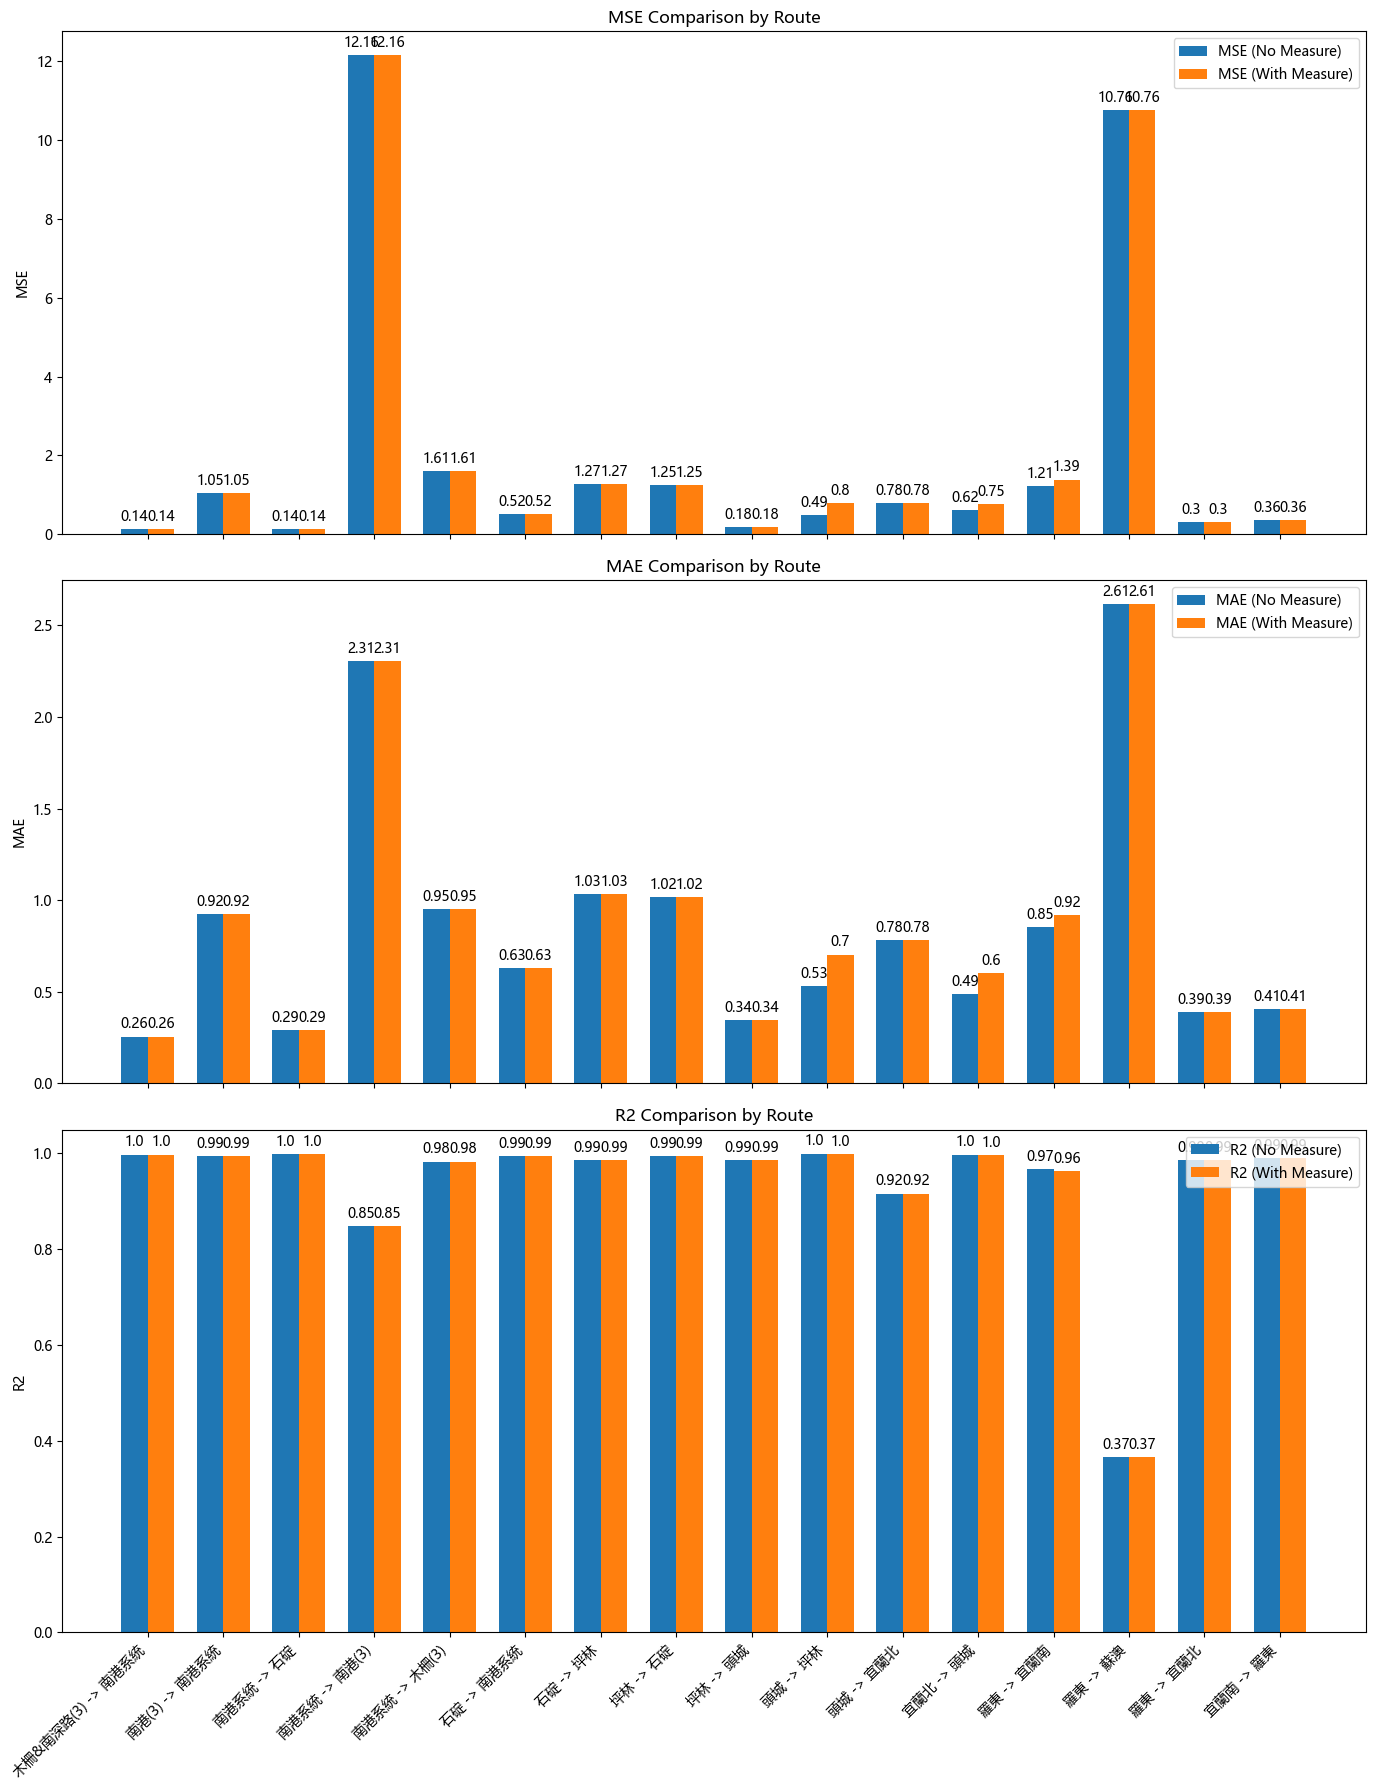

In [38]:
results_df = pd.DataFrame(results, columns=['route', 'mse_no_measure', 'mae_no_measure', 'r2_no_measure', 'mse_with_measure', 'mae_with_measure', 'r2_with_measure'])
print(results_df)

# Plot MSE, MAE, R2 comparison
fig, ax = plt.subplots(3, 1, figsize=(14, 18), sharex=True)

width = 0.35  # the width of the bars
x = np.arange(len(results_df))

# Plot MSE
rects1 = ax[0].bar(x - width/2, results_df['mse_no_measure'], width, label='MSE (No Measure)')
rects2 = ax[0].bar(x + width/2, results_df['mse_with_measure'], width, label='MSE (With Measure)')
ax[0].set_ylabel('MSE')
ax[0].set_title('MSE Comparison by Route')
ax[0].legend()

# Plot MAE
rects3 = ax[1].bar(x - width/2, results_df['mae_no_measure'], width, label='MAE (No Measure)')
rects4 = ax[1].bar(x + width/2, results_df['mae_with_measure'], width, label='MAE (With Measure)')
ax[1].set_ylabel('MAE')
ax[1].set_title('MAE Comparison by Route')
ax[1].legend()

# Plot R2
rects5 = ax[2].bar(x - width/2, results_df['r2_no_measure'], width, label='R2 (No Measure)')
rects6 = ax[2].bar(x + width/2, results_df['r2_with_measure'], width, label='R2 (With Measure)')
ax[2].set_ylabel('R2')
ax[2].set_title('R2 Comparison by Route')
ax[2].legend()

ax[2].set_xticks(x)
ax[2].set_xticklabels(results_df['route'], rotation=45, ha='right')

# Attach a text label above each bar in rects, displaying its height.
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1, ax[0])
autolabel(rects2, ax[0])
autolabel(rects3, ax[1])
autolabel(rects4, ax[1])
autolabel(rects5, ax[2])
autolabel(rects6, ax[2])

fig.tight_layout()
plt.show()